# Import Libraries

In [1]:
# importing the libraries
import os
import pandas as pd
from selenium import webdriver
         
chrome_options = webdriver.ChromeOptions()

# saving the downloadable files, on the web page, in the working directory
prefs = {"download.default_directory" : os.getcwd()}
chrome_options.add_experimental_option("prefs",prefs)

#chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
chrome_options.add_argument(f'user-agent={user_agent}')

In [2]:
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [117]:
import time
import sys
import numpy as np
# Set the seed value
np.random.seed(42)
from glob import glob
import requests

import re
from itertools import chain

from bs4 import BeautifulSoup
from bs4 import BeautifulSoup as bs

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
# download the chrome driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

In [5]:
# open the link to scrap
driver.get("https://onlydatajobs.com/")
wait = WebDriverWait(driver, 10)

# get the html page source
html = driver.page_source
soup = bs(html, 'html.parser')

In [6]:
jobs_category_links = soup.findAll('div',attrs={'class':'browse-custom__content-item active'})

In [7]:
refined_job_links = []

for h2 in jobs_category_links:
    # find 'a' tags to get the link
    links = h2.findAll('a')
    for a in links:
        # append every search link
        card_links = a['href']
        refined_job_links.append(card_links)

In [8]:
for url in refined_job_links:
    if 'business-analyst' in url and 'technical' not in url:
        business_analysis_link = url

In [9]:
# open the link to scrap
driver.get(business_analysis_link)
wait = WebDriverWait(driver, 10)

# get the html page source
html = driver.page_source
soup = bs(html, 'html.parser')

In [10]:
# Wait for the popup to appear
popup = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "cookiesAlertMsg")))

# Click the "I agree and accept cookies" button
button = popup.find_element(By.ID, "cookies_alert_btn")
button.click()
time.sleep(3)

In [11]:
# Click the check box for Greater London

try:
    label = driver.find_element(By.XPATH, "//label[@for='checkbox-8-0']")
    # Click the label to select the checkbox
    label.click()
except:
    time.sleep(15)
    label = driver.find_element(By.XPATH, "//label[@for='checkbox-8-0']")
    label.click()

In [12]:
# get the html page source
html = driver.page_source
soup = bs(html, 'html.parser')

In [13]:
# get the links for all the cards for business analyst job in Greater London

search_results = soup.findAll('div',attrs={'class':'s-res'})
# to store the links
card_links = []
i = 0

while True:
    # iterate over all the div elements
    for div in search_results:
        # find 'a' tags to get the link
        links = div.findAll('a')
        # iterate over the links to append them into the links
        for a in links:
            # using href as link is stored in href.
            card_links.append('https://onlydatajobs.com' + a['href'])
            
    i = i + 1
    if i > 33:
        break
    
    try:
        # Wait for the NEXT button to become clickable
        next_button = 'https://onlydatajobs.com' + soup.findAll('a',attrs={'class':'nextButton'})[0]['href']
    except:
        break

    driver.get(next_button)
    wait = WebDriverWait(driver, 10)

    # get the html page source
    html = driver.page_source
    soup = bs(html, 'html.parser')
    time.sleep(1)
    search_results = soup.findAll('div',attrs={'class':'s-res'})

In [14]:
# remove the duplicate urls
card_links = list(set(card_links))

In [15]:
# Create bigrams for the skills that contain two words
def get_bigrams(sentence):
    words = sentence.split()
    bigrams = []
    for i in range(len(words)-1):
        bigram = ','.join((words[i] + " " + words[i+1]))
        bigrams.append(bigram)
    return bigrams

In [16]:
# This will filter the skills from the job description.
def job_skills(business_analyst_keywords):
    job_description = str(soup.find('td', class_='job_desc_td'))
    job_description_soup = BeautifulSoup(job_description, 'html.parser')
    all_text = str(job_description_soup.get_text())
    all_text = all_text.lower()
    
    # Convert job description to lower case and split into words
    all_text = all_text.lower().split()
    
    
    #print(all_text)
    
    bigrams = []
    for i in range(len(all_text) - 1):
        bigrams.append([all_text[i] + " " + all_text[i+1]])
        
    bigrams = list(np.array(bigrams).ravel())
    # Initialize a list to store the skills related to Business Analyst
    business_analyst_skills = []

    # Loop through each word in the job description and check if it matches any of the keywords related to Business Analyst
    for word in all_text:
        for keyword in business_analyst_keywords:
            # Use regular expression to check if the keyword matches the word in the job description
            if re.match(keyword, word):
                business_analyst_skills.append(keyword)
                
    # Loop through each word in the job description and check if it matches any of the keywords related to Business Analyst
    for word in bigrams:
        for keyword in business_analyst_keywords:
            # Use regular expression to check if the keyword matches the word in the job description
            if re.match(keyword, word):
                business_analyst_skills.append(keyword)
    
    business_analyst_skills = list(pd.DataFrame(business_analyst_skills).value_counts().index)
    business_analyst_skills = [i[0] for i in business_analyst_skills][::-1]
    # Print the list of skills related to Business Analyst
    return business_analyst_skills

In [17]:
# Define a list of keywords related to Business Analyst.
# These should be in small letters.

business_analyst_keywords = ['risk management', 'data analysis', 'problem solving', 'requirements gathering', \
                            'problem-solving', 'business acumen', 'project management', \
                             'data visualization', 'market research', \
                             'financial analysis', 'forecasting', 'strategic planning', 'risk management', \
                              'sales', 'marketing', 'brand management', \
                             'product management', 'team leadership', 'negotiation', 'contract management', \
                             'vendor management', 'supply chain management', 'logistics', 'operations management', \
                             'quality control', 'lean manufacturing', 'six sigma', 'e-commerce', \
                             'web development', 'digital marketing', 'social media marketing', 'search engine optimization', \
                             'content marketing', 'email marketing', 'customer retention', 'lead generation', \
                             'pricing strategy', 'inventory management', 'budgeting', 'financial modeling', \
                             'cash flow management', 'tax planning', 'mergers and acquisitions', 'business intelligence', \
                             'competitive analysis', 'intellectual property', 'patent law', 'agile methodologies',\
                             'business-driven', 'agile development', 'agile process', 'risk identification', \
                             'stakeholder management', 'agile scrum', 'agile methodology', \
                             'design thinking', 'agile/lean', 'agile/lean scrum', 'product backlog', 'backlog refinement',\
                            'retrospective', 'sprint review', 'risk identification','stakeholder management', 'actuarial analysis',\
                            'financial modeling', 'qualitative analysis', 'quantitative', 'reinsurance contracts', 'annuity insurance'\
                            'process optimization', 'business strategy', 'data management', 'financial modelling',\
                            'accounting', 'excel', 'business continuity', 'risk assessment', 'business development', 'sap',\
                            'java', 'interpersonal skills', 'change management', 'it principles', 'process analyst', 'statistics',
                            'statistical', 'probability theory']

# 'customer experience'
#business_analyst_keywords = skills_keywords
required_skills = job_skills(business_analyst_keywords)
print(required_skills)

[]


In [18]:
# Open every job page, using card links, and retrieve information

job_names = list()
company_names = list()
job_levels = list()
salaries = list()
cities = list()
skills_for_job = list()
industries = list()

counter = 0
for i in card_links:
    
    if counter > 335:
        break
    driver.get(i)
    wait = WebDriverWait(driver, 10)

    # get the html page source
    html = driver.page_source
    soup = bs(html, 'html.parser')
    time.sleep(1)
    
    job_title = soup.find('h1',attrs={'class':'page-title'}).text
    job_names.append(job_title)
    
    employer_tag = soup.find('td', {'class': 'f vac_item_employer'})
    link_tag = employer_tag.find_next_sibling('td').find('a')
    company_name = link_tag.text.strip()
    company_names.append(company_name)
    
    job_type = soup.find('td', class_='vac_item_job_type').find_next_sibling('td').text.strip()
    job_levels.append(job_type)
    
    salary = soup.find('td', class_='vac_item_salary_text').find_next_sibling('td').text.strip()
    salaries.append(salary)
    
    city = soup.find('td', class_='vac_item_city').find_next_sibling('td').text.strip()
    cities.append(city)
    
    required_skills = job_skills(business_analyst_keywords)
    skills_for_job.append(required_skills[0])
    
    try:
        industry = soup.find('td', class_='vac_item_industry').find_next_sibling('td').text.strip()
    except:
        industry = None
    industries.append(industry)
    
    counter = counter + 1

In [19]:
df_dict = {'title': job_names, 'company': company_names, \
           'job_level': job_levels, 'salary': salaries, 'city': cities, 'skills': skills_for_job, 'industry': industries}

In [20]:
df = pd.DataFrame(df_dict).drop_duplicates()

# Save the dataset. BA_GL, Business Analyst in Greater London
# pd.DataFrame(df_dict).to_csv('BA_GL.csv', index = False)

In [21]:
print(f'Shape of the dataframe {df.shape}')

Shape of the dataframe (303, 7)


# Data Analysis

In [22]:
# df = pd.read_csv('BA_GL.csv')

In [23]:
df.isnull().sum()

title         0
company       0
job_level     0
salary        0
city          0
skills        0
industry     43
dtype: int64

In [24]:
# All the unique skills present in the dataset
print(np.unique(df['skills'].values))

['accounting' 'agile development' 'agile methodologies'
 'agile methodology' 'agile process' 'agile scrum' 'backlog refinement'
 'budgeting' 'business acumen' 'business continuity'
 'business development' 'business strategy' 'change management'
 'contract management' 'data analysis' 'data management'
 'data visualization' 'design thinking' 'excel' 'financial analysis'
 'financial modelling' 'forecasting' 'intellectual property'
 'interpersonal skills' 'it principles' 'market research' 'marketing'
 'negotiation' 'operations management' 'problem solving' 'problem-solving'
 'process analyst' 'product backlog' 'product management'
 'project management' 'qualitative analysis' 'quality control'
 'quantitative' 'reinsurance contracts' 'requirements gathering'
 'risk assessment' 'risk identification' 'risk management' 'sales' 'sap'
 'six sigma' 'sprint review' 'stakeholder management' 'strategic planning'
 'team leadership' 'vendor management' 'web development']


In [25]:
agile_skills = ['agile methodology', 'agile process', 'agile development', 'agile scrum']

for i in agile_skills:
    df['skills'].replace(i, 'agile methodologies', inplace = True)
    
agile_skills = ['excel']

for i in agile_skills:
    df['skills'].replace(i, 'data analysis', inplace = True)
    
agile_skills = ['risk_identification']

for i in agile_skills:
    df['skills'].replace(i, 'risk management ', inplace = True)

In [26]:
# Companies for which the industry value is None
print(np.unique(df[df.isnull().any(axis=1)]['company'].values))

['AXS' 'Accor Hotel Group' 'Acxiom' 'Bank Lombard Odier & Co' 'Berkley'
 'Blenheim Chalcot' 'Brown Brothers Harriman & Co' 'CMS' 'Carbonplace'
 'Civil Aviation Authority' 'Commoditas' 'Coople'
 'Creative Artists Agency' 'Crystal Cruises' 'Enabling Functions'
 'Equantiis' 'Equus Software' 'Farsight Consulting'
 'Financial Ombudsman Service' 'Gorilla' 'Greyspark' 'H&M Group'
 'Hugo & Cat' 'Landytech' 'Lombard International' 'Newham'
 'Notting Hill Genesis' "Parkinson's" 'Salary Finance' 'Satago'
 'Segantii Capital Management' 'SellerPlex' 'Square Enix'
 'TMP Worldwide Advertising & Communications' 'The NPD Group' 'Tickmill'
 'Tower Research Capital' 'Turo' 'Vanderlande Industries B.V'
 'Vista Global' 'WEX']


In [27]:
# Companies and their corresponding industries. These are for the missing values.
industry_dict = {
    'Creative Artists Agency': 'Entertainment',
    'Lombard International': 'Insurance',
    'Greyspark': 'Consultancy',
    'Hugo & Cat': 'Advertising/Marketing',
    'Vanderlande Industries B.V': 'Engineering & Manufacturing',
    'Salary Finance': 'Financial Services',
    'Crystal Cruises': 'Hospitality',
    'H&M Group': 'Retail',
    'Tickmill': 'Financial Services',
    'Equantiis': 'Consultancy',
    'Enabling Functions': 'Consultancy',
    'Square Enix': 'Gaming',
    'Acxiom': 'Technology',
    'Turo': 'Transportation',
    'Notting Hill Genesis': 'Real Estate',
    'Segantii Capital Management': 'Investment',
    "Parkinson's": 'Healthcare',
    'Bank Lombard Odier & Co': 'Banking',
    'Landytech': 'Technology',
    'Carbonplace': 'Environmental',
    'WEX': 'Payment',
    'Equus Software': 'Technology',
    'Financial Ombudsman Service': 'Financial Services',
    'Brown Brothers Harriman & Co': 'Banking',
    'Commoditas': 'Commodities',
    'Tower Research Capital': 'Investment',
    'Satago': 'Financial Services',
    'Berkley': 'Insurance',
    'SellerPlex': 'E-commerce',
    'Blenheim Chalcot': 'Venture Capital',
    'The NPD Group': 'Market Research',
    'Civil Aviation Authority': 'Travel & Aviation',
    'AXS': 'Ticketing',
    'TMP Worldwide Advertising & Communications': 'Advertising/Marketing',
    'Gorilla': 'Digital',
    'Farsight Consulting': 'Consultancy',
    'Coople': 'Staffing',
    'Accor Hotel Group': 'Hospitality',
    'Vista Global': 'Travel & Aviation',
    'CMS': 'Legal',
    'Newham': 'Government & Public Sector'
}

for key, value in industry_dict.items():
    df.loc[df['company'] == key, 'industry'] = df.loc[df['company'] == key, 'industry'].fillna(value)

In [28]:
print(np.unique(df[df.isnull().any(axis=1)]['company'].values))

[]


In [63]:
df.loc[df['job_level'] == 'Permanent', 'job_level'] = 'Mid-Senior to Senior'

In [64]:
# Save the refined dataset
df.to_csv('df_refined.csv', index = False)

In [137]:
# read the dataframe
df = pd.read_csv('df_refined.csv')
df.head()

,title,company,job_level,salary,city,skills,industry
0,Business Analyst - Group Treasury job in London,Macquarie Bank,Mid-Senior to Senior,Competitive,London,interpersonal skills,Financial Services
1,"Consultant, Business Analyst, Defence and Secu...",Deloitte (UK),Mid-Senior to Senior,Competitive,London,problem solving,Consultancy
2,Business Analyst (London Market Operations) jo...,Arch Europe Insurance Services,Mid-Senior to Senior,Competitive,London,requirements gathering,Insurance
3,Business Analyst job in London,CBRE,Mid-Senior to Senior,Competitive,London,problem solving,Property & Construction
4,Business Analyst/Project Manager - London Mark...,Capco,Mid-Senior to Senior,Competitive,London,data analysis,Consultancy


## Based on the data you have collected, and using Python, identify the most commonly required skill from your data set

In [138]:
top_skills = df[['skills']].value_counts()[:10]
top_skills_names = top_skills.index
top_skills_names = [i[0] for i in top_skills_names]
top_skills_values = top_skills.values
top_skills = pd.DataFrame({'skills': top_skills_names, 'counts': top_skills_values})

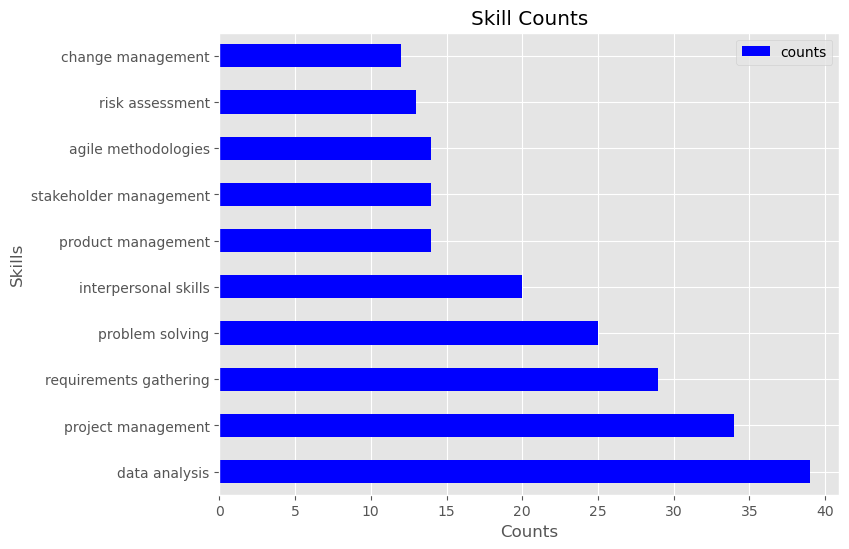

In [139]:
# Create the bar plot
ax = top_skills.plot(kind='barh', x='skills', y='counts', color='blue', figsize=(8,6))
ax.set_xlabel('Counts')
ax.set_ylabel('Skills')
ax.set_title('Skill Counts')
plt.show()

**The most required skill is Data Analysis**

In [140]:
df['industry'].value_counts()[:10]

Financial Services             108
Consultancy                     37
Technology                      33
Insurance                       25
Media                           11
Retail                          10
Energy                           9
Advertising/Marketing            8
Fintech                          7
Engineering & Manufacturing      7
Name: industry, dtype: int64

## Conduct a principal component analysis of the job postings, using the data you have collected.

In [141]:
# Create a matrix of the skills data. We will use skills data for PCA
# and the component scores and the industry data while performing kmeans
skills_matrix = df['skills'].str.get_dummies(sep=', ')
industry_matrix = df['industry'].str.get_dummies(sep=', ')

# Perform PCA on the skills matrix
num_components = 40
pca = PCA(n_components=num_components, random_state = 42)
pca.fit(skills_matrix)

####################################################################
# component scores
####################################################################
component_scores = pca.transform(skills_matrix)

### a. how many components to select — here you should justify your choice based on statistical and interpretation arguments, and

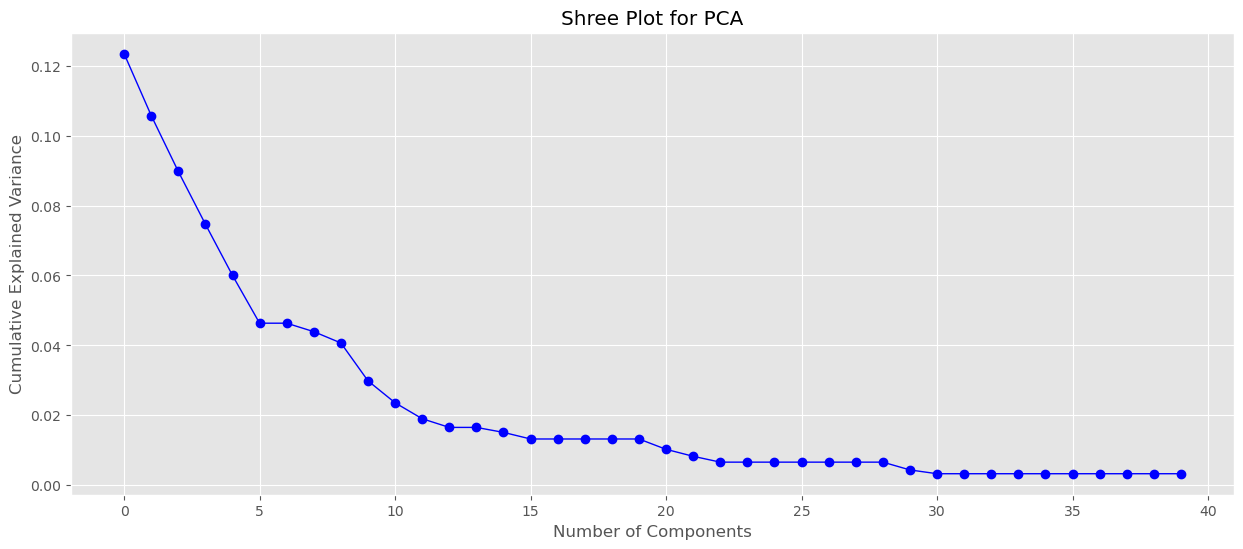

In [146]:
# Extract the eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# Define the plot size and style
plt.figure(figsize=(15,6))
plt.style.use('ggplot')

# Create the Shree plot
plt.plot(pca.explained_variance_, color='blue', linewidth=1, marker='o')

# Add axis labels and a title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Shree Plot for PCA')

# Show the plot
plt.show()

**We have used Scree plot to determine the number of components. After analysing Scree plot, we will use 5 as the number of components because the curve starts to level off from that point.**

In [123]:
# Perform PCA after scree plot
num_components = 5
pca = PCA(n_components=num_components, random_state = 42)
pca.fit(skills_matrix)

####################################################################
# component scores
####################################################################
component_scores = pca.transform(skills_matrix)

In [124]:
component_names = [f'Component {i}' for i in range(1, num_components + 1)]
component_df = pd.DataFrame(component_scores, columns=component_names)

# combining component scores and industry data
component_df = pd.concat([component_df, industry_matrix], axis = 1)
component_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Advertising/Marketing,Banking,Charity & Not For Profit,Commodities,Consultancy,...,Property & Construction,Real Estate,Retail,Security & Defence,Staffing,Technology,Ticketing,Transportation,Travel & Aviation,Venture Capital
0,-0.085500,-0.130927,-0.185503,-0.606660,0.703269,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.120335,-0.225348,-0.627032,0.631177,0.191743,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.178524,-0.532658,0.693509,0.239779,0.121211,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.120335,-0.225348,-0.627032,0.631177,0.191743,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0.854567,0.221085,0.110695,0.094021,0.063144,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## b. How to interpret the selected components?

In [125]:
# Get the loadings for each principal component
loadings = pca.components_

for i in range(0, num_components):
    # Print the loadings for the first principal component
    print(f"Loadings for PC{i + 1}:")
    print(loadings[i])

    # Get the contribution of each variable to the first principal component
    pc1_loadings = abs(loadings[0])
    pc1_loadings = pc1_loadings / np.sum(pc1_loadings)
    print('')
    # Print the variable contributions to the first principal component
    print(f"Variable contributions to PC{i + 1}:")
    print(pc1_loadings)
    print('-' * 80)

Loadings for PC1:
[-0.00476327 -0.02383519 -0.00109233 -0.00109233 -0.00224659 -0.00109233
 -0.00476327 -0.00476327 -0.01881333 -0.00109233  0.89418749 -0.00224659
 -0.00476327 -0.00224659 -0.00109233 -0.00224659 -0.00224659 -0.00109233
 -0.04587879 -0.00109233 -0.00224659 -0.00613858 -0.00224659 -0.00109233
 -0.08071419 -0.01082833 -0.00346821 -0.00613858 -0.02383519 -0.41171511
 -0.00109233 -0.00109233 -0.00613858 -0.00109233 -0.13890368 -0.02122081
 -0.00109233 -0.00476327 -0.00760185 -0.00109233 -0.00476327 -0.00224659
 -0.02383519 -0.00109233 -0.00109233 -0.00109233 -0.00109233]

Variable contributions to PC1:
[0.00266346 0.01332785 0.00061079 0.00061079 0.00125622 0.00061079
 0.00266346 0.00266346 0.01051979 0.00061079 0.5        0.00125622
 0.00266346 0.00125622 0.00061079 0.00125622 0.00125622 0.00061079
 0.0256539  0.00061079 0.00125622 0.00343249 0.00125622 0.00061079
 0.0451327  0.00605484 0.00193931 0.00343249 0.01332785 0.23021744
 0.00061079 0.00061079 0.00343249 0.000610

**Loadings refer to the correlation between each variable and the principal component, indicating the strength and direction of their relationship. Positive loadings indicate that the variable is positively correlated with the principal component, while negative loadings indicate a negative correlation.**

**Looking at the given values, we can see that for both PC1 and PC2, the variables with the highest loadings are the 11th variable (with a loading of 0.8942) and the 30th variable (with a loading of 0.8049). These variables are the strongest contributors to these components. The variable contributions for both components are the same and are equal to 0.5, indicating that all variables contribute equally to these components.**

**Looking at the loadings for PC3 and PC4, it seems that PC3 is most influenced by variables 10, 29, and 35, while PC4 is most influenced by variables 10, 29, and 34. However, many of the variables have non-zero loadings for both PC3 and PC4, which suggests that they share some level of influence over these components.**

**The variable contributions to PC3 and PC4 are identical, indicating that the same variables are driving both components to a similar extent. Specifically, variables 10, 29, and 35 have the highest contributions to PC3, while variables 10, 29, and 34 have the highest contributions to PC4. This reinforces the notion that these variables are particularly important for both components.**

**The variable contributions for both PC3 and PC4 are very small for most of the variables, indicating that they don't contribute much to these components.**

**PC5 has a proportionally smaller amount of variance explained compared to the first four principal components. The loadings for PC5 show that several variables have small but negative coefficients, while some have positive coefficients.**

**The variable contributions to PC5 indicate that variable 11 (with a contribution of 0.5) has the highest influence on this component, while variable 19 has the second-highest contribution of 0.0257. The remaining variables have relatively small contributions.**

## Performing Elbow method

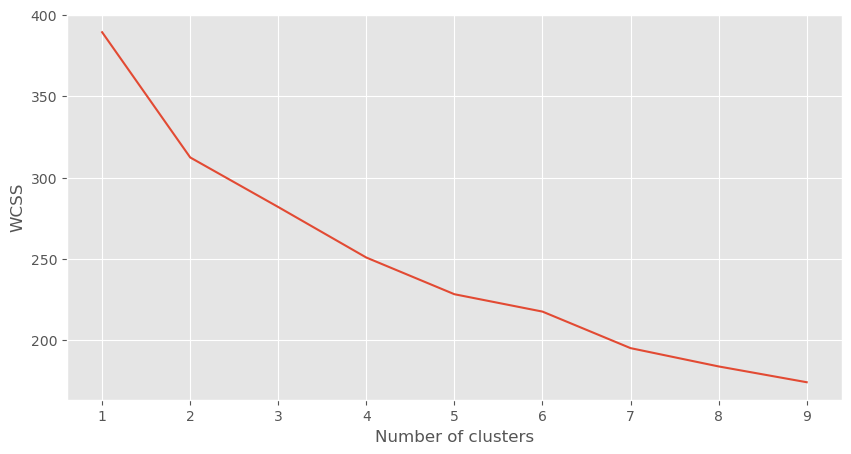

In [126]:
# Determine how many clusters to select
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init = 'k-means++')
    kmeans.fit(component_df)
    inertias.append(kmeans.inertia_)
plt.figure(figsize = (10, 5))
plt.plot(range(1, 10), inertias)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## How many clusters should be picked — here you should justify your choice based on statistical and interpretation arguments.

**After analyzing the WCSS plot, we have identified the elbow point at 2 where the WCSS curve starts to level off. Therefore, we have decided to choose 2 clusters as the optimal number of clusters for our analysis.**

## Perform K-means clustering on the component scores and other data from the original dataset

## Also create a profile of your clusters, using heat maps and/or snake plots.

### Test case 1

In [127]:
# Perform K-means clustering on the component scores and other data from the original dataset
kmeans = KMeans(n_clusters=2, random_state=42, init = 'k-means++')
cluster_labels = kmeans.fit_predict(component_df)

component_df['cluster'] = cluster_labels

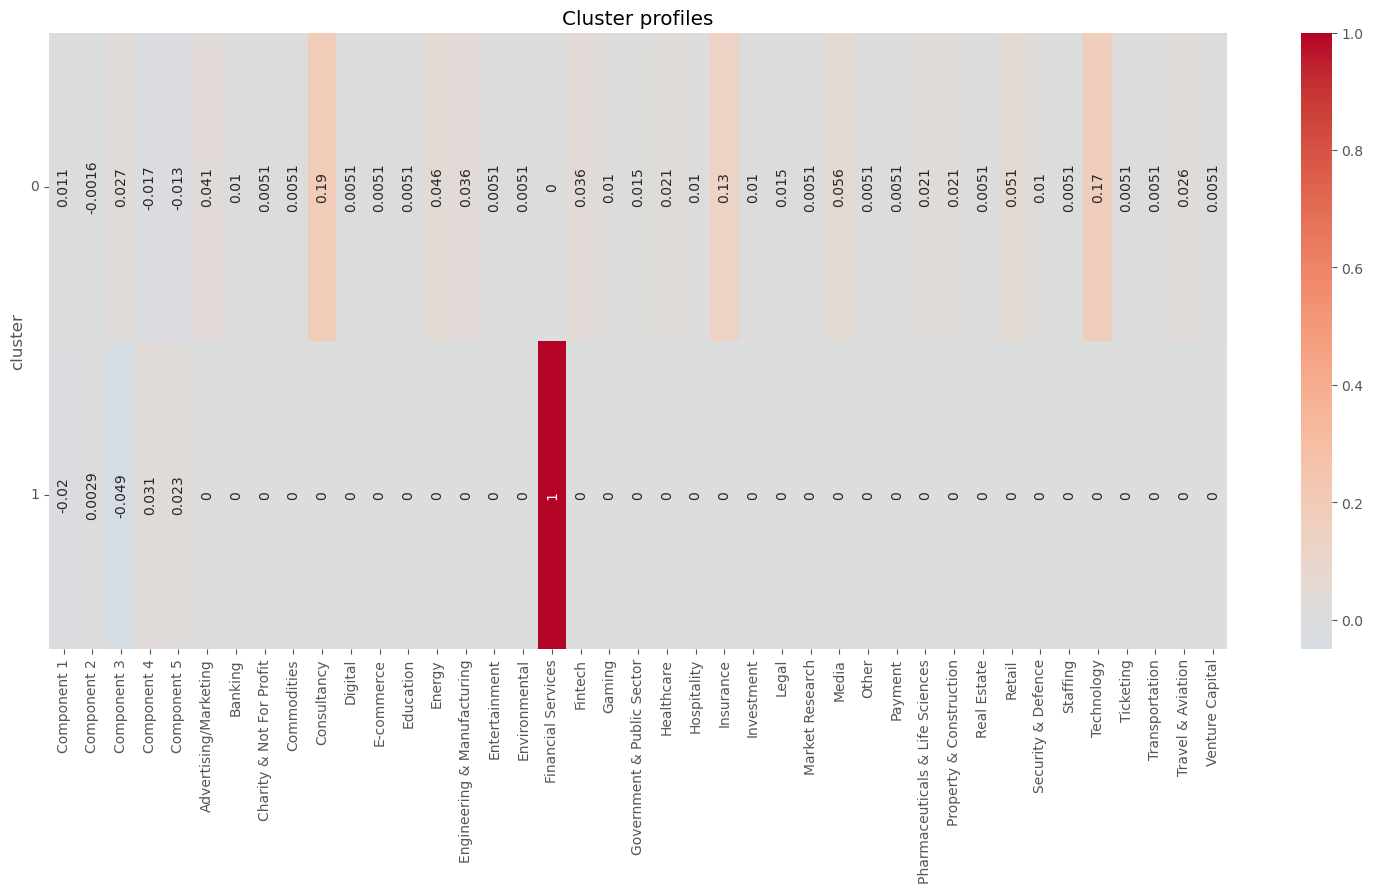

In [128]:
# Create a profile of the clusters

cluster_means = component_df.groupby('cluster').mean()
fig, ax = plt.subplots(figsize=(19, 8))
sns.heatmap(cluster_means, cmap='coolwarm', center=0, annot=True, ax=ax, annot_kws={"rotation": 90})
plt.yticks(rotation=0)
plt.title('Cluster profiles')
plt.show()

## Test Case 2

In [129]:
# Perform K-means clustering on the component scores and other data from the original dataset
kmeans = KMeans(n_clusters=6, init = 'k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(component_df)

component_df['cluster'] = cluster_labels

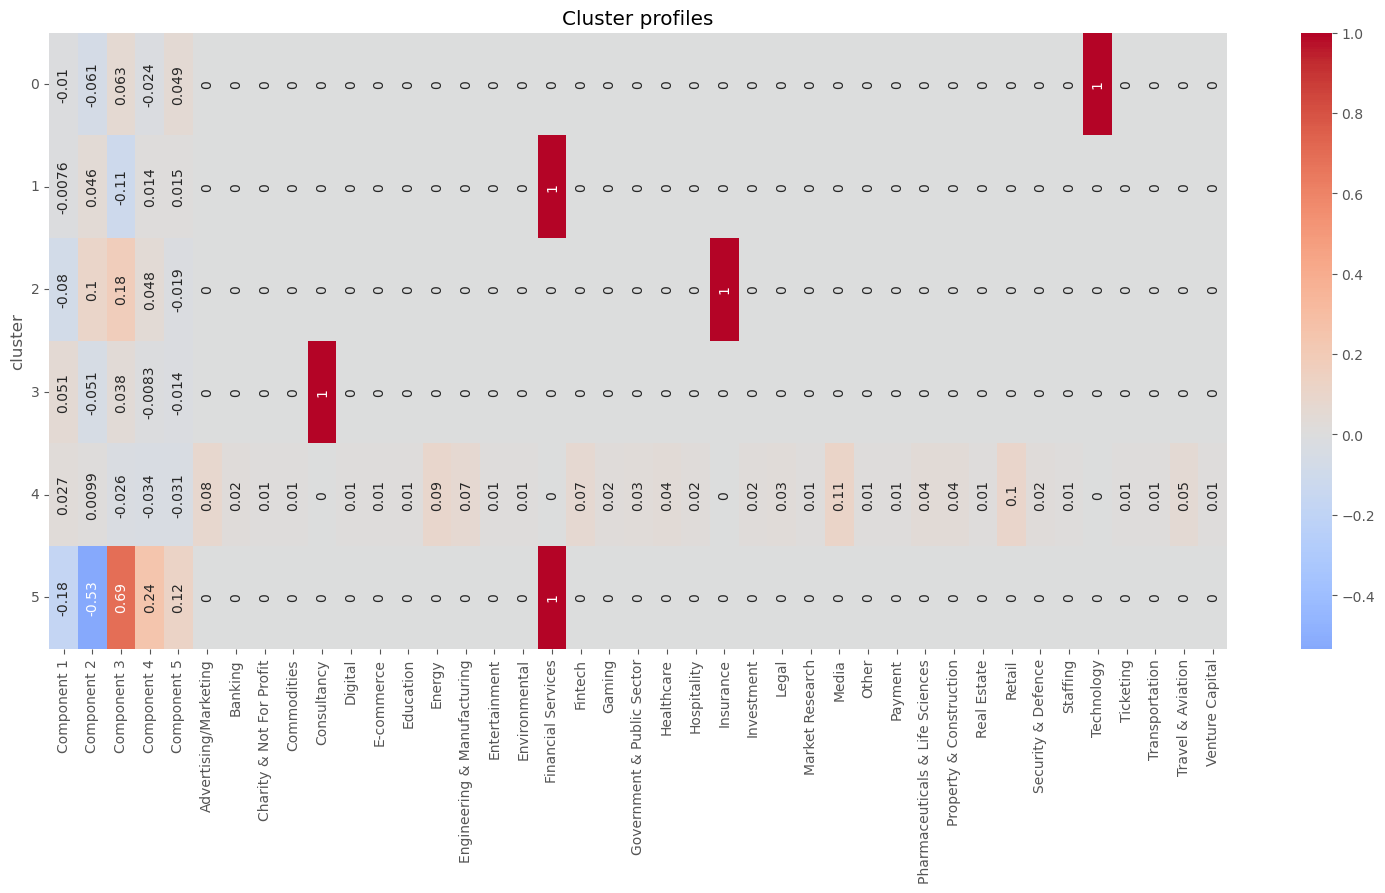

In [130]:
# Create a profile of the clusters

cluster_means = component_df.groupby('cluster').mean()
fig, ax = plt.subplots(figsize=(19, 8))
sns.heatmap(cluster_means, cmap='coolwarm', center=0, annot=True, ax=ax, annot_kws={"rotation": 90})
plt.yticks(rotation=0)
plt.title('Cluster profiles')
plt.show()

## Describe the key features of job postings in each cluster

In test case one, we have used 2 as the number of clusters according to the Elbow plot, but we can cleary see that most of the clusters have no or very less value for most of the industries and the components. Cluster 1 has high value for Financial Services.

For second test case, we have selected a random the number for number of clusters, that is 6 in our case, to see the result. Here the result is slightly improved for the components. Cluster 0 has high value for Technology, Cluster 1 and cluster 5 have high values for Financial services. Cluster 2 has high value for Insurence, and Cluster 3 has high value for Consultancy.